In [53]:
import matplotlib.pyplot as plt
import numpy as np
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')
plt.style.use("default")
font = {'size'   : 16}
plt.rc('font', **font)

In [54]:
def parseTiming(fname):
    with open(fname, 'r') as f:
        for line in f:
            if "diverged" in line: raise Exception(f"iterations in file {fname} diverged!")
            if "Braid" in line: continue
            if "wall time" in line: return float(line.split()[-1])

def parseTol(fname, tol):
    with open(fname, 'r') as f:
        for line in f:
            if "diverged" in line: raise Exception(f"iterations in file {fname} diverged!")
            if "Begin" in line: continue
            if "not available" in line: continue
            if "Solver Stats" in line: continue
            if "Braid" in line and "wall time" in line:
                res = float(line.split()[5].split(',')[0])
                if res <= tol:
                    return float(line.split()[-1])

def parseIters(fname):
    with open(fname, 'r') as f:
        for line in f:
            if "max iterations" in line: continue
            if "Max" in line: continue
            if "iterations" in line: return float(line.split()[-1])

In [55]:
ncores = (16, 32, 64, 128, 256, 512, 1024)
mlevels = (4, 4, 4, 4, 4, 4, 4)
thetas = np.zeros(len(ncores))
deltas = np.zeros(len(ncores))
delta3 = np.zeros(len(ncores))
mgrits = np.zeros(len(ncores))
ranks = (2, 4, 8, 9, 16, 32, 64)
rank = 9
bad_pts = []
tol = 1e-9

serial = parseTiming("ks_ml1")

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    thetas[i] = parseTol(f"ks_theta_nc{nc}", tol)
    if np.isnan(thetas[i]):
        thetas[i] = parseTiming(f"ks_theta_nc{nc}")
        bad_pts.append((nc, thetas[i]))

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    deltas[i] = parseTol(f"ks_Delta{rank}_nc{nc}", tol)
    if np.isnan(deltas[i]):
        deltas[i] = parseTiming(f"ks_Delta{rank}_nc{nc}")
        bad_pts.append((nc, deltas[i]))

# for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    # delta3[i] = parseTol(f"ks_Delta{rank}_nc{nc}_cf16", tol)
    # if np.isnan(delta3[i]):
        # delta3[i] = parseTiming(f"ks_Delta{rank}_nc{nc}_cf16")
        # bad_pts.append((nc, delta3[i]))


for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    mgrits[i] = parseTol(f"ks_nc{nc}", tol)
    if np.isnan(mgrits[i]):
        mgrits[i] = parseTiming(f"ks_nc{nc}")
        bad_pts.append((nc, mgrits[i]))

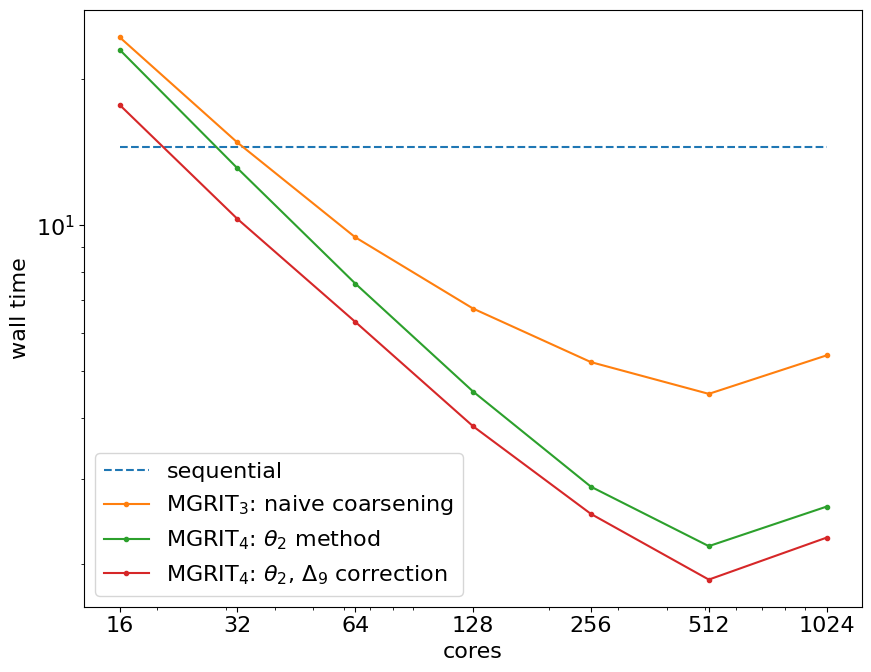

In [56]:
fig, ax = plt.subplots(figsize=(9,7))
ax.loglog(ncores, serial*np.ones(len(ncores)), '--', label="sequential")
ax.loglog(ncores, mgrits, '.-', label=r"MGRIT$_3$: naive coarsening")
ax.loglog(ncores, thetas, '.-', label=r"MGRIT$_4$: $\theta_2$ method")
# ax.loglog(ncores, delta3, '.-', label=fr"MGRIT$_3$: $\theta_2$, $\Delta_{{{rank}}}$ correction")
ax.loglog(ncores, deltas, '.-', label=fr"MGRIT$_4$: $\theta_2$, $\Delta_{{{rank}}}$ correction")
[ax.plot(*pt, 'rx') for pt in bad_pts]
ax.set_xlabel("cores")
ax.set_ylabel("wall time")
ax.legend()
plt.xticks(ncores, ncores)
# plt.ylim((1e0, 1e2))
plt.tight_layout()
plt.savefig("strong_scaling_KS_tf4.png", dpi=300)

In [57]:
serial/mgrits

array([0.59403807, 0.97936007, 1.53543739, 2.15371902, 2.77672969,
       3.22818018, 2.68915195])

In [58]:
serial/thetas

array([0.63019691, 1.1064526 , 1.91220699, 3.19262753, 5.01540796,
       6.64886651, 5.51122776])

In [59]:
serial/deltas

array([0.81889994, 1.40723583, 2.29343813, 3.76481273, 5.70650748,
       7.79275753, 6.38525507])

In [60]:
speedups = []
for rank in ranks:
    speedups.append(serial/parseTol(f"ks_Delta{rank}_nc512", tol))
speedups

[5.774712749003984,
 7.320469191919192,
 7.105161274509804,
 7.79275752688172,
 7.175509405940594,
 6.6795064516129035,
 5.751797222222222]

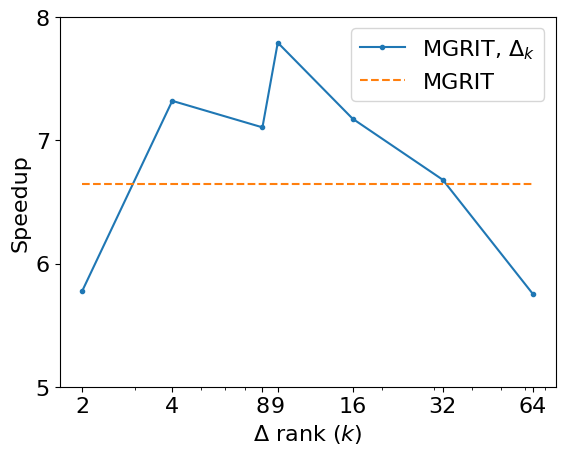

In [61]:
speedup_th = serial/thetas[-2]
plt.semilogx(ranks, speedups, '.-', label=r"MGRIT, $\Delta_k$")
plt.semilogx((ranks[0], ranks[-1]), (speedup_th, speedup_th), '--', label="MGRIT")
plt.xticks(ranks, ranks)
plt.yticks(range(5,9), range(5,9))
plt.xlabel(r"$\Delta$ rank ($k$)")
plt.ylabel("Speedup")
plt.legend()
plt.savefig("compare_ranks.png", dpi=600)
plt.show()